# Brain Tumor Classification With Data Augmentation

### Import Libraries

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import tensorflow as tf

RANDOM_SEED = 123

### Create Directory for Train, Test and Validation Dataset

In [2]:
!apt-get install tree
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (557 kB/s)
Selecting previously unselected package tree.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [3]:
# connect to drive  if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Split Data in Train, Test and Validation Set





In [4]:
IMAGE_PATH = '/content/drive/MyDrive/FMI/dataset/archive/brain_tumor_dataset/'

for CLASS_ in os.listdir(IMAGE_PATH):

    if not CLASS_.startswith('.'):
        IMG_NUM = len(os.listdir(IMAGE_PATH + CLASS_))

        for (n, FILE_NAME) in enumerate(os.listdir(IMAGE_PATH + CLASS_)):
            image = IMAGE_PATH + CLASS_ + '/' + FILE_NAME
            if n < 5:
                shutil.copy(image, 'TEST/' + CLASS_.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(image, 'TRAIN/'+ CLASS_.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(image, 'VAL/'+ CLASS_.upper() + '/' + FILE_NAME)

### Function to load resized images as arrays 

In [35]:
def load_data(folder_path, img_size=(100,100)):
    x = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(folder_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(folder_path + path):
                if not file.startswith('.'):
                    image = cv2.imread(folder_path + path + '/' + file)
                    x.append(image)
                    y.append(i)
            i += 1
    x = np.array(x)
    y = np.array(y)
    return x, y, labels


### Load Data to Test, Train and Validation Directory

In [36]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]
<ipython-input-35-b1ba693805de>:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 2/2 [00:00<00:00, 15.82it/s]


### Plot Number of images in each classes in each set 

In [11]:
data = dict()
data[0] = []
data[1] = []
for name in (y_train, y_val, y_test):
    data[0].append(np.sum(name == 0))
    data[1].append(np.sum(name == 1))

figure1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=data[0],
    name='No',
    marker=dict(color='blue'),
    opacity=0.7
)
figure2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=data[1],
    name='Yes',
    marker=dict(color='orange'),
    opacity=0.7
)
data = [figure1, figure2]
layout = go.Layout(
    title='Number of classes in each set',
    xaxis={'title': 'Set Name'},
    yaxis={'title': 'Count of classes'}
)
fig = go.Figure(data, layout)
fig.update_xaxes(tickfont=dict(size=15))
iplot(fig)

### Finding extreme points and crop images and add Gausian Blur

In [19]:
def crop_images(set_name):
    new_set = []
    for img in set_name:
        grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        grey = cv2.GaussianBlur(grey, (5, 5), 0)

        # threshold the image and perform 2 iterations of erosions and dilations
        thresh_ = cv2.threshold(grey, 45, 255, cv2.THRESH_BINARY)[1]
        thresh_ = cv2.erode(thresh_, None, iterations=2)
        thresh_ = cv2.dilate(thresh_, None, iterations=2)

        # find contours in thresholded image and take the largest one
        contours = cv2.findContours(thresh_.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        c = max(contours, key=cv2.contourArea)

        # finding extreme points on contour
        extremeLeft = tuple(c[c[:, :, 0].argmin()][0])
        extremeRight = tuple(c[c[:, :, 0].argmax()][0])
        extremeTop = tuple(c[c[:, :, 1].argmin()][0])
        extremeBot = tuple(c[c[:, :, 1].argmax()][0])
        
        ADD_PIXEL = 0
        new_image = img[extremeTop[1]-ADD_PIXEL:extremeBot[1]+ADD_PIXEL, extremeLeft[0]-ADD_PIXEL:extremeRight[0]+ADD_PIXEL].copy()
        new_set.append(new_image)

    return np.array(new_set)

### Crop Images

In [21]:
# apply cropping for each set
X_train_crops = crop_images(set_name=X_train)
X_val_crops = crop_images(set_name=X_val)
X_test_crops = crop_images(set_name=X_test)

<ipython-input-19-d5f20a14dd6e>:27: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [23]:
# Function to save images 
def save_images(x_set, y_set, Folder_Name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(Folder_Name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(Folder_Name+'YES/'+str(i)+'.jpg', img)
        i += 1

### Save Croped Images in Directory

In [25]:
# Creating new folder
!mkdir TRAIN_CROPS TEST_CROPS VAL_CROPS TRAIN_CROPS/YES TRAIN_CROPS/NO TEST_CROPS/YES TEST_CROPS/NO VAL_CROPS/YES VAL_CROPS/NO

# Saving crop images to new folder
save_images(X_train_crops, y_train, Folder_Name='TRAIN_CROPS/')
save_images(X_val_crops, y_val, Folder_Name='VAL_CROPS/')
save_images(X_test_crops, y_test, Folder_Name='TEST_CROPS/')

### Function to preprocess images 





In [27]:
# Resizing and applying VGG-15 preprocessing
def preprocess_images(set_name, img_size):
    new_set = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        new_set.append(preprocess_input(img))
    return np.array(new_set)

In [28]:
X_train_preprocess = preprocess_images(X_train_crops, IMG_SIZE)
X_test_preprocess = preprocess_images(X_test_crops, IMG_SIZE)
X_val_preprocess = preprocess_images(X_val_crops, IMG_SIZE)

### Perform Data Augmentation and Transformation
    Flip and Rotation
    Translation 
    Rescaling
    Shearing 
    Brightness

In [29]:
TRAIN_DIR = 'TRAIN_CROPS/'
VAL_DIR = 'VAL_CROPS/'

train_datagenerator = ImageDataGenerator(
    rotation_range=15,            # Rotation
    width_shift_range=0.1,        # Translation
    height_shift_range=0.1,       # Translation
    rescale=1./255,               # Rescaling
    shear_range=0.1,              # Shearing
    brightness_range=[0.5, 1.5],  # Brightness
    horizontal_flip=True,         # Flip
    vertical_flip=True,           # Flip
    preprocessing_function=preprocess_input
)

test_datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagenerator.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagenerator.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### Load VGG16 Base Model for Transfer Learning

In [ ]:
# Give Path to model
vgg16_weight_path = '/content/drive/MyDrive/FMI/model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

### Add Layers to VGG16 Base Model 





In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


### Train Model

In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=0,
    callbacks=[es]
)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.6149 - precision: 0.6593 - recall: 0.8476

6/6 [==============================] - 9s 504ms/step - loss: 0.7037 - accuracy: 0.6149 - precision: 0.6593 - recall: 0.8476
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.6087 - precision: 0.6357 - recall: 0.8367

6/6 [==============================] - 3s 422ms/step - loss: 0.7128 - accuracy: 0.6087 - precision: 0.6357 - recall: 0.8367
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.6302 - precision: 0.6691 - recall: 0.7881

6/6 [==============================] - 3s 488ms/step - loss: 0.6580 - accuracy: 0.6302 - precision: 0.6691 - recall: 0.7881
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6273 - precision: 0.6484 - recall: 0.8469

6/6 [==============================] - 3s 440ms/step - loss: 0.6420 - accuracy: 0.6273 - precision: 0.6484 - recall: 0.8469
Epoch 5/30
6/6 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.6025 - precision: 0.6957 - recall: 0.6400

6/6 [==============================] - 3s 430ms/step - loss: 0.6712 - accuracy: 0.6025 - precision: 0.6957 - recall: 0.6400
Epoch 6/30
6/6 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6460 - precision: 0.6875 - recall: 0.7778

6/6 [==============================] - 3s 428ms/step - loss: 0.6459 - accuracy: 0.6460 - precision: 0.6875 - recall: 0.7778
Epoch 7/30
5/6 [========================>.....] - ETA: 0s - loss: 0.6236 - accuracy: 0.6812 - precision: 0.7321 - recall: 0.7961

6/6 [==============================] - 3s 398ms/step - loss: 0.6209 - accuracy: 0.6832 - precision: 0.7321 - recall: 0.7961
Epoch 8/30
5/6 [========================>.....] - ETA: 0s - loss: 0.6100 - accuracy: 0.6500 - precision: 0.6786 - recall: 0.7917

6/6 [==============================] - 3s 402ms/step - loss: 0.6095 - accuracy: 0.6522 - precision: 0.6786 - recall: 0.7917
Epoch 9/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5893 - accuracy: 0.6187 - precision: 0.6916 - recall: 0.7255

6/6 [==============================] - 3s 407ms/step - loss: 0.5866 - accuracy: 0.6211 - precision: 0.6944 - recall: 0.7282
Epoch 10/30
6/6 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.6719 - precision: 0.6897 - recall: 0.8475

6/6 [==============================] - 3s 503ms/step - loss: 0.6249 - accuracy: 0.6719 - precision: 0.6897 - recall: 0.8475
Epoch 11/30
6/6 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.6894 - precision: 0.6807 - recall: 0.8710

6/6 [==============================] - 3s 416ms/step - loss: 0.5916 - accuracy: 0.6894 - precision: 0.6807 - recall: 0.8710
Epoch 12/30
6/6 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6875 - precision: 0.7185 - recall: 0.8151

6/6 [==============================] - 3s 493ms/step - loss: 0.6172 - accuracy: 0.6875 - precision: 0.7185 - recall: 0.8151
Epoch 13/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5877 - accuracy: 0.6750 - precision: 0.7238 - recall: 0.7677

6/6 [==============================] - 3s 392ms/step - loss: 0.5915 - accuracy: 0.6708 - precision: 0.7170 - recall: 0.7677
Epoch 14/30
6/6 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6708 - precision: 0.7333 - recall: 0.7549

6/6 [==============================] - 3s 429ms/step - loss: 0.6090 - accuracy: 0.6708 - precision: 0.7333 - recall: 0.7549
Epoch 15/30
6/6 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.7135 - precision: 0.7222 - recall: 0.8739

6/6 [==============================] - 5s 682ms/step - loss: 0.5780 - accuracy: 0.7135 - precision: 0.7222 - recall: 0.8739
Epoch 16/30
6/6 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6522 - precision: 0.6780 - recall: 0.8163

6/6 [==============================] - 3s 419ms/step - loss: 0.6459 - accuracy: 0.6522 - precision: 0.6780 - recall: 0.8163
Epoch 17/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5544 - accuracy: 0.7312 - precision: 0.7500 - recall: 0.8614

6/6 [==============================] - 3s 400ms/step - loss: 0.5602 - accuracy: 0.7267 - precision: 0.7436 - recall: 0.8614
Epoch 18/30
6/6 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.7329 - precision: 0.7864 - recall: 0.7941

6/6 [==============================] - 3s 528ms/step - loss: 0.5424 - accuracy: 0.7329 - precision: 0.7864 - recall: 0.7941
Epoch 19/30
6/6 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6719 - precision: 0.7165 - recall: 0.7712

6/6 [==============================] - 3s 500ms/step - loss: 0.5940 - accuracy: 0.6719 - precision: 0.7165 - recall: 0.7712
Epoch 20/30
6/6 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6894 - precision: 0.7257 - recall: 0.8119

6/6 [==============================] - 3s 521ms/step - loss: 0.6231 - accuracy: 0.6894 - precision: 0.7257 - recall: 0.8119
Epoch 21/30
6/6 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.7143 - precision: 0.7155 - recall: 0.8646

6/6 [==============================] - 3s 430ms/step - loss: 0.5593 - accuracy: 0.7143 - precision: 0.7155 - recall: 0.8646
Epoch 22/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5511 - accuracy: 0.6938 - precision: 0.7193 - recall: 0.8283

6/6 [==============================] - 3s 391ms/step - loss: 0.5483 - accuracy: 0.6957 - precision: 0.7217 - recall: 0.8300
Epoch 23/30
6/6 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.7391 - precision: 0.7521 - recall: 0.8835

6/6 [==============================] - 3s 424ms/step - loss: 0.5119 - accuracy: 0.7391 - precision: 0.7521 - recall: 0.8835
Epoch 24/30
6/6 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7081 - precision: 0.7426 - recall: 0.7812

6/6 [==============================] - 3s 533ms/step - loss: 0.5856 - accuracy: 0.7081 - precision: 0.7426 - recall: 0.7812
Epoch 25/30
6/6 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.6832 - precision: 0.7115 - recall: 0.7789

6/6 [==============================] - 3s 420ms/step - loss: 0.5752 - accuracy: 0.6832 - precision: 0.7115 - recall: 0.7789
Epoch 26/30
6/6 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7240 - precision: 0.7600 - recall: 0.8051

6/6 [==============================] - 3s 511ms/step - loss: 0.5468 - accuracy: 0.7240 - precision: 0.7600 - recall: 0.8051
Epoch 27/30
6/6 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.7702 - precision: 0.7712 - recall: 0.9010

6/6 [==============================] - 3s 420ms/step - loss: 0.5021 - accuracy: 0.7702 - precision: 0.7712 - recall: 0.9010
Epoch 28/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5503 - accuracy: 0.7188 - precision: 0.7500 - recall: 0.8447

6/6 [==============================] - 3s 407ms/step - loss: 0.5515 - accuracy: 0.7143 - precision: 0.7500 - recall: 0.8365
Epoch 29/30
6/6 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7640 - precision: 0.7479 - recall: 0.9175

6/6 [==============================] - 3s 427ms/step - loss: 0.5117 - accuracy: 0.7640 - precision: 0.7479 - recall: 0.9175
Epoch 30/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5785 - accuracy: 0.6812 - precision: 0.7426 - recall: 0.7500

6/6 [==============================] - 3s 392ms/step - loss: 0.5754 - accuracy: 0.6832 - precision: 0.7451 - recall: 0.7525


### Function to Plot Confusion Matrix

In [33]:
def confusion_matrix_plot(confusion_mtx, classes, title,
                          normalize=False,
                          cmap=plt.cm.pink_r):

    plt.figure(figsize = (6,6))
    plt.imshow(confusion_mtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    thresh = confusion_mtx.max() / 2.
    confusion_mtx = np.round(confusion_mtx,2)
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, confusion_mtx[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Model Performace Plot

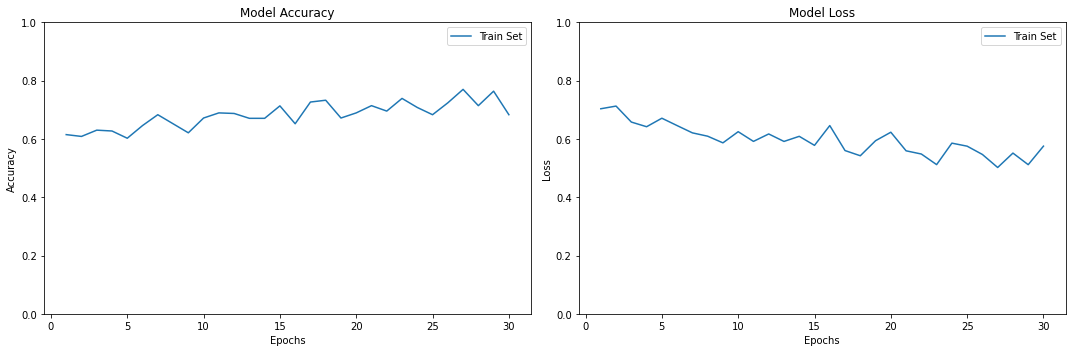

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.ylim(0.,1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Predictions on Validation Data

2/2 [==============================] - 0s 194ms/step


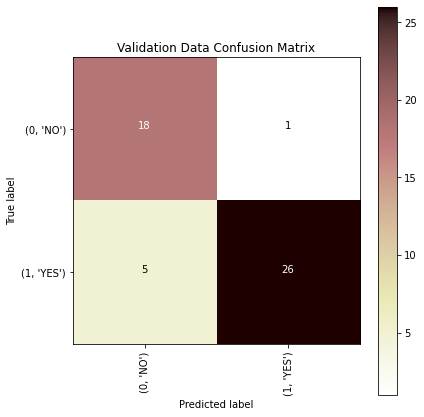

Validation Accuracy = 0.88
Precision: 0.9629629629629629
Recall: 0.8387096774193549
F1 Score: 0.896551724137931


In [ ]:
predictions = model.predict(X_val_preprocess)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = confusion_matrix_plot(confusion_mtx, classes = list(labels.items()), title="Validation Data Confusion Matrix", normalize=False)

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f' % accuracy)

precision = precision_score(y_val, predictions)
print('Precision:', precision)

recall = recall_score(y_val, predictions)
print('Recall:',recall)

f1 = f1_score(y_val, predictions)
print('F1 Score:',f1)


### Predictions on Test Data 

1/1 [==============================] - 0s 19ms/step


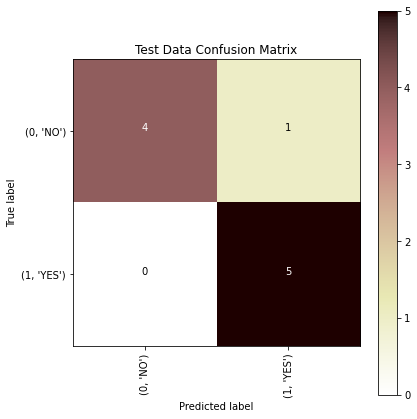

Test Accuracy = 0.90
Precision: 0.8333333333333334
Recall: 1.0
F1 Score: 0.9090909090909091


In [ ]:
predictions = model.predict(X_test_preprocess)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = confusion_matrix_plot(confusion_mtx, classes = list(labels.items()), title="Test Data Confusion Matrix", normalize=False)

print('Test Accuracy = %.2f' % accuracy)

precision = precision_score(y_test, predictions)
print('Precision:', precision)

recall = recall_score(y_test, predictions)
print('Recall:',recall)

f1 = f1_score(y_test, predictions)
print('F1 Score:',f1)

In [ ]:
# Save Model
model.save('VGG_model.h5')